In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from mcmodels.regressors import NadarayaWatson
import math

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec
from mcmodels.core.utils import get_injection_hemisphere_id

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
def get_ccf_data(cache, experiment_id):

    eid_data = ExperimentData(experiment_id)
    eid_data.data_quality_mask = cache.get_data_mask(experiment_id)[0]
    eid_data.injection_signal = cache.get_injection_density(experiment_id)[0]
    eid_data.injection_fraction = cache.get_injection_fraction(experiment_id)[0]
    eid_data.projection_signal = cache.get_projection_density(experiment_id)[0]
    return(eid_data)
#     return {
#         "data_quality_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_signal" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_signal" : cache.get_projection_density(experiment_id)[0]
#     }

def get_connectivity_data(cache, structure_ids, experiments_exclude, remove_injection = False):

    connectivity_data = ConnectivityData()
    for sid in structure_ids:
        print(sid)
        sid_data = StructureData(sid)
        #deprecated language
        model_data = ModelData(cache, sid)
        sid_data.eids = model_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=None)
        for eid in sid_data.eids:
            
            eid_data = get_ccf_data(cache, eid)#ExperimentData(eid)
            eid_data.data_mask_tolerance = .5
            #ccf_data = get_ccf_data(cache, eid)
            eid_data.injection_signal_true = eid_data.injection_signal * eid_data.injection_fraction
            if remove_injection == True:
                pass #remove injection fraction from projection
            #injection_signal should = projection_signal in some locations (nonzero)
            #why do we use partial?
            #mask_func = partial(_mask_data_volume,data_mask=eid_data.data_mask,tolerance=eid_data.data_mask_tolerance)
            eid_data.injection_qmasked  = _mask_data_volume(eid_data.injection_signal_true,eid_data.data_quality_mask,eid_data.data_mask_tolerance)
            eid_data.projection_qmasked  = _mask_data_volume(eid_data.projection_signal,eid_data.data_quality_mask,eid_data.data_mask_tolerance) #mask_func(eid_data.projection_signal) 
            #eid_data.centroid = compute_centroid(eid_data.injection_qmasked)
            sid_data.experiment_datas[eid] = eid_data
        connectivity_data.structure_datas[sid] = sid_data
    return(connectivity_data)

def get_data_matrices(connectivity_data):
    
    structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].injection_mask = Mask.from_cache(cache,structure_ids=[sid],hemisphere_id=2)
        connectivity_data.structure_datas[sid].projection_mask = Mask.from_cache(cache,structure_ids=default_structure_ids, hemisphere_id=3)
        for eid in experiment_ids:
            connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec = connectivity_data.structure_datas[sid].injection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked)
            connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec = connectivity_data.structure_datas[sid].projection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].projection_qmasked)
        connectivity_data.structure_datas[sid].injections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].projections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].centroids = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].centroid for eid in connectivity_data.structure_datas[sid].eids])
        
        
    return(connectivity_data)


def get_regionalized_normalized_data(connectivity_data, cache, source_order, ipsi_key, contra_key): #experiments_minor_structures):
    '''
    :param msvds: Class dictionary holding data
    :param cache: AllenSDK cache
    :param source_order: Source key (tautologically ipsilateral due to hemisphere mirroring)
    :param ipsi_key: Ipsilateral target key
    :param contra_key:  Contralateral target key
    :return: msvds: Class dictionary holding average data
    '''
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        # print()
        structure_data = connectivity_data.structure_datas[sid]
        #nexp = msvd.projections.shape[0]

        #minor_structures = np.unique(experiments_minor_structures[sid])
        #nmins = len(minor_structures)

        projections = structure_data.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        structure_data.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        structure_data.reg_proj_vcount_norm = reg_proj_vcount_norm
        structure_data.reg_proj_vcount_norm_renorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_proj_vcount_norm, axis=1), 1)
        
        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=source_order)
        source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

        injections = structure_data.injections
        reg_ipsi_inj = unionize(injections, source_key)
        structure_data.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_counts[np.newaxis, :])
        structure_data.reg_inj_vcount_norm = reg_inj_vcount_norm
        
        structure_data.reg_proj_vcount_norm_injnorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_inj_vcount_norm, axis=1), 1)
        connectivity_data.structure_datas[sid] = structure_data
        #msvd.reg_proj_vcountnorm_totalnorm =
    connectivity_data.ipsi_target_regions = ipsi_target_regions
    connectivity_data.contra_target_regions = contra_target_regions        
    connectivity_data.target_regions = np.concatenate([ipsi_target_regions, contra_target_regions])
    return (connectivity_data)

# def get_normalized_data(connectivity_data, normalization = None):

#     structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
#     for sid in structure_ids:
#         if normalization == None:
#             pass
#         if normalization == 'injection':
#             nc = np.sum(connectivity_data.structure_datas[sid].injections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc
#         if normalization == 'total':
#             nc = np.sum(conn_data[sid].projections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc

#     return(connectivity_data)


def compute_centroid(injection_density):
    """Computes centroid in index coordinates.

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    Returns
    -------
        centroid of injection_density in index coordinates.
    """
    nnz = injection_density.nonzero()
    coords = np.vstack(nnz)

    return np.dot(coords, injection_density[nnz]) / injection_density.sum()

def get_cre_status(data_info, connectivity_data):
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    exps = np.asarray(data_info.index.values , dtype = np.int)
    creline = {}
    for sid in major_structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        nexp = len(experiment_ids)
        creline[sid] = np.zeros(nexp, dtype = object)
        for i in range(len(experiment_ids)):
            index = np.where(exps == experiment_ids[i])[0][0]
            creline[sid][i] = data_info['transgenic-line'].iloc[index]
    return(creline)


In [4]:
class ConnectivityData():
    
    def __init__(self):
        self.structure_datas = {}    
    
    def get_injection_hemisphere_ids(self):
        
        structure_datas = self.structure_datas
        
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_injection_hemisphere_ids()
            
        self.structure_datas = structure_datas
        
        
    def align(self):
        
        structure_datas= self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].align()
        self.structure_datas = structure_datas

    def get_centroids(self):
        
        structure_datas = self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_centroids()
            
        self.structure_datas = structure_datas
        
class StructureData():
    
    def __init__(self, sid):
        self.experiment_datas = {}
        
    def get_injection_hemisphere_ids(self):   
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
             experiment_datas[eid].injection_hemisphere_id = get_injection_hemisphere_id(experiment_datas[eid].injection_qmasked, majority=True)
        self.experiment_datas = experiment_datas
        
    def align(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            if experiment_datas[eid].injection_hemisphere_id == 1:
                experiment_datas[eid].flip()
        self.experiment_datas = experiment_datas

    def get_centroids(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            experiment_datas[eid].centroid = compute_centroid(experiment_datas[eid].injection_qmasked)
        self.experiment_datas = experiment_datas        
        
class ExperimentData():
    
    def __init__(self, eid):
        2+2
    
    #def get_injection_hemisphere():
        
        
    def flip(self):
        """Reflects experiment along midline.

        Returns
        -------
        self - flipped experiment
        """

        self.injection_qmasked = self.injection_qmasked[..., ::-1]
        self.projection_qmasked = self.projection_qmasked[..., ::-1]
        self.injection_signal = self.injection_signal[..., ::-1]
        self.projection_signal = self.projection_signal[..., ::-1]
        self.injection_signal_true = self.injection_signal_true[..., ::-1]
        #self.projection_signal_true = self.projection_signal_true[..., ::-1]
        self.injection_fraction = self.injection_fraction[..., ::-1]
        self.data_quality_mask = self.data_quality_mask[...,::-1]
        
        #return self        

def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def get_summarystructure_dictionary(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        summarystructure_dictionary[sid] = get_minorstructures(eids, data_info)
    return (summarystructure_dictionary)


def get_leaves_ontologicalorder(connectivity_data, ontological_order):
    '''

    :param msvd:
    :param ontological_order:
    :return: The leaf order associated with the 'ontological_order' of summary structures
    '''
    sid0 = list(connectivity_data.structure_datas.keys())[0]
    #eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
    levs = connectivity_data.structure_datas[sid0].projection_mask.reference_space.structure_tree.child_ids(
        ontological_order)
    flat_list = np.asarray([item for sublist in levs for item in sublist])

    nss = len(levs)
    leavves = np.asarray([])
    for i in range(nss):
        if len(levs[i]) > 0:
            leavves = np.append(leavves, levs[i])
        else:
            leavves = np.append(leavves, ontological_order[i])
    return (leavves)

from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(proj, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),proj ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

def get_cre_dist_cv(proj, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [5]:
def get_minorstructures(eids, data_info):
    
    experiments_minors = np.zeros(len(eids), dtype=object)

    for i in range(len(eids)):
        experiment_id = eids[i]
        experiments_minors[i] = ai_map[data_info['primary-injection-structure'].loc[experiment_id]]
    
    return(experiments_minors)

def get_summarystructures(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].summary_structures = get_minorstructures(eids, data_info)
    return (connectivity_data)

def get_leafs(connectivity_data, data_info,leafs):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].leafs = leafs[sid]
    return (connectivity_data)

In [13]:

connectivity_data = get_connectivity_data(cache, major_structure_ids[4:5], experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data = get_data_matrices(connectivity_data)

creline = get_cre_status(data_info, connectivity_data)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data = get_summarystructures(connectivity_data, data_info)
connectivity_data = get_leafs(connectivity_data, data_info,leafs)

315


In [ ]:
def get_crelines(connectivity_data, creline):

    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        connectivity_data.structure_datas[sid].crelines = creline[sid]
        
    return(connectivity_data)

In [ ]:
connectivity_data = get_crelines(connectivity_data, creline)

In [ ]:
# def get_minorstructures(eids, data_info):
#     #eids = np.asarray(list(msvd.experiments.keys()))
#     experiments_minors = np.zeros(len(eids), dtype=object)

#     for i in range(len(eids)):
#         experiment_id = eids[i]
#         experiments_minors[i] = data_info['primary-injection-structure'].loc[experiment_id]

#     return (experiments_minors)


In [ ]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])


In [ ]:
connectivity_data = get_regionalized_normalized_data(connectivity_data, cache, ontological_order, ipsi_targetkey, contra_targetkey)

In [ ]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
indices_creleaf = {}
indices_creleaf2ormore = {}
creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids[4:5]:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    #indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    #indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    #indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    #indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])

    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]

    indices_creleaf[sid] = get_indices(np.asarray(creleafs_merged[sid]))
    indices_creleaf2ormore[sid] = screen_index_matrices(indices_creleaf[sid], indices_creleaf[sid])

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

In [ ]:
# #wrong dist (not remove)... try to recreate old result
# frac_learn = np.ones(12)
# frac_learn[4] = .01
# sls = {}
# for m in range(4,5):
#     sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
#     print(sid)
#     #msvd = msvds[sid]
#     cres = creline[sid]
#     eminors = leafs[sid]
#     #means_cast, cs = get_cre_similarity(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, cres,eminors, colnames)
#     #cre_dist2 = get_cre_dist_cv(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, means_cast, eminors,cres)
#     qqq = get_loss_surface_control(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,frac_learn[m],creline[sid],leafs[sid])


In [ ]:
#sls[sid] = get_smoothed_losses(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,qqq, cre_dist2)

In [ ]:
# gammas = np.asarray([0.1,.5,1,2,10,20,40])
# for sid in major_structure_ids[4:5]:
#     connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists_near(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
#                                                                                        sls[sid]**6, 
#                                                                                        #pds,                                       
#                                                                                        #(sls[sid] - np.nanmin(sls[sid]))**.5,
#                                                                                        gammas, 
#                                                                                        indices_leaf2ormore[sid], 
#                                                                                        indices_leaf2ormore[sid])
# a= [list(range(5))]
# keys = np.asarray(list(itertools.product(*a)))

# reg_proj_vcount_norm_renorms= {}
# nwloocv_leaf_leaf2 = {}
# for sid in major_structure_ids[4:5]:
#     reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
#     nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

# eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

# losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
#best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
#meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

In [ ]:
nreg = 1
best_gamma_leaf_leaf2 = 0.01 * np.ones(nreg)

In [ ]:
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [ ]:
source_ordering = ontological_order_leaves

In [ ]:
#ems = np.asarray([ai_map[experiments_minor_structures[sid][i]] for i in range(experiments_minor_structures[sid].shape[0])])

In [ ]:
# #crelines = creline[sid]
# def get_cremean_difference(msvd, exps, means_cast, cre,crelines ,region,qqq):

#     nsamp = len(exps)
#     #cres = np.unique(crelines)
#     #ncre  = len(cres)
#     credist = np.empty((nsamp))
#     im = Mask.from_cache(cache,
#         structure_ids=[region],
#         hemisphere_id=2)

#     nvox = im.coordinates.shape[0]
#     #cdiff = np.zeros((nvox,nsamp,3))
#     #cdist = np.zeros((nvox,nsamp))
#     cre_str = crelines[exps]
#     for i in range(nsamp):
#         print(i, 'get cre diff')
#         cremean_difference[i] = np.linalg.norm(means_cast[ia_map[region]][cre] -
#                                     means_cast[ia_map[region]][crelines[i]]
#                                     means_cast.loc[tuple([cre_str[i], ia_map[ems[exps[i]]]])])

# #     cdiff = np.asarray([(im.coordinates[j] - msvd.centroids[exps]) for j in range(nvox)])
# #     cdist = np.linalg.norm(cdiff, axis = 2)
# #     nexp = cdist.shape[1]
# #     cremean_difference = np.zeros((nvox,nexp))
# #     for i in range(nvox):
# #         print(i, 'get voxel loss')
# #         for j in range(nexp):
# #             cdiz = cdist[i,j] / dsnorm
# #             crdiz = credist[j] / csnorm
# #             cremean_difference[i,j] = qqq.predict(np.asarray([[cdiz, crdiz]]))   
            
#     return(cremean_difference)

In [ ]:
# def get_means(projections, cres, sids):
#     cre_means = {}
#     cre_types = np.unique(cres)
#     sid_types = np.unique(sids)
#     for i in range(len(sid_types)):
#         cre_means[sid_types[i]] = {}
#         sid_inds = np.where(sids == sid_types[i])[0]
#         for j in range(len(cre_types)): 
#             cre_inds = np.where(cres == cre_types[j])[0]
#             cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
#     return(cre_means)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

In [7]:
def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        #dists_i = dists[i,:] - np.min(dists[i,:])
        dists_i = dists[:,i] - np.min(dists[:,i])
        weights_i = np.exp(- dists_i / gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

In [8]:
def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)

In [9]:
def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

In [10]:
def get_loss_surface(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances = get_cre_distances(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma)
    return(surface)

In [11]:
def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    return(surface)

In [12]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .01
sls = {}
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface = get_loss_surface(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,creline[sid],leafs[sid],frac_learn[m])

AttributeError: 'StructureData' object has no attribute 'reg_proj_vcount_norm_renorm'

In [ ]:
def plot_loss_surface(surface):
    xs = np.linspace(0, surface.coordinates_normed[:,0].max(), 100)
    ys = np.linspace(0, surface.coordinates_normed[:,1].max(), 100)
    preds = np.empty((100,100))
    for x in range(100):
        for y in range(100):
            preds[x,y] = surface.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

    mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

    #%matplotlib inline
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(mxy[:,:,0], 
               mxy[:,:,1], 
               preds, s= .1)

    #ax.set_axis_off()
    ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
    ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
    ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)    
plot_loss_surface(connectivity_data.structure_datas[sid].loss_surface)

In [ ]:
# sid = 315#128
# #msid = 886
# major_region = 315
# gamma = .01
# reg_pred = get_region_prediction(cache, structure_data = connectivity_data.structure_datas[315], structures  = connectivity_data.structure_datas[315].leafs, prediction_region = 430, cre = 'Cux2-IRES-Cre', gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)

In [ ]:
#means = get_means(projections, [prediction_region], cres)

In [ ]:
def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_vcount_norm_renorm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        
    
    return(output)

def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(cres)
    
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions     
                                                      
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        #print(iy)
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)   
    
    #reorder = np.concatenate([ipsi_indices, contra_indices])  
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i)
            sid = structure_major_dictionary[source_ordering[i]]
            connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_summarystructure_major_dictionary(connectivity_data):
    
    structure_major_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].summary_structures)
        nstrs = len(strs_sid)
        for s in range(nstrs):
            structure_major_dictionary[strs_sid[s]] = sid
        
    return(structure_major_dictionary)

def get_major_summarystructure_dictionary(connectivity_data):
    
    major_structure_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].summary_structures)
        major_structure_dictionary[sid] = np.asarray(strs_sid, dtype = int)
        
    return(major_structure_dictionary)

def get_leaf_major_dictionary(connectivity_data):
    
    structure_major_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].leafs)
        nstrs = len(strs_sid)
        for s in range(nstrs):
            structure_major_dictionary[strs_sid[s]] = sid
        
    return(structure_major_dictionary)

def get_major_leaf_dictionary(connectivity_data):
    
    major_structure_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].leafs)
        major_structure_dictionary[sid] = np.asarray(strs_sid, dtype = int)
        
    return(major_structure_dictionary)

In [ ]:
connectivity_data.summarystructure_major_dictionary = get_summarystructure_major_dictionary(connectivity_data)
connectivity_data.major_summarystructure_dictionary = get_major_summarystructure_dictionary(connectivity_data)
connectivity_data.leaf_major_dictionary = get_leaf_major_dictionary(connectivity_data)
connectivity_data.major_leaf_dictionary = get_major_leaf_dictionary(connectivity_data)

In [ ]:
connectivity_matrices = get_connectivity_matrices(connectivity_data, ['Cux2-IRES-Cre'], structure_dict = leafs,source_ordering = source_ordering_isocortex,target_ordering= target_ordering, structure_major_dictionary = connectivity_data.leaf_major_dictionary)

In [ ]:
c = 0
cre_str_ind = np.where(~np.isnan(np.sum(connectivity_matrices[c], axis = 1) ))[0]
sns.heatmap(connectivity_matrices[c][cre_str_ind], vmax = .02)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


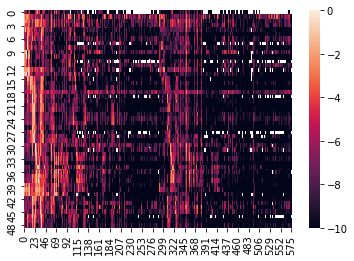

In [505]:
sns.heatmap(np.log(connectivity_matrices[c][cre_str_ind]), vmax= 0, vmin = -10)

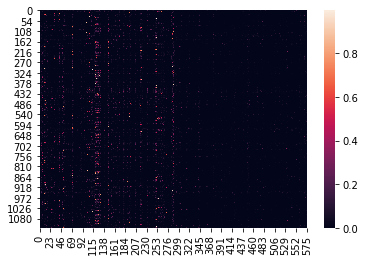

In [464]:
sns.heatmap(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm)

In [488]:

    #def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary):
    source_ordering = source_ordering_isocortex
    structure_major_dictionary = connectivity_data.leaf_major_dictionary
    
    cres = ['Cux2-IRES-Cre']
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(cres)
    
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions     
                                                      
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        #print(iy)
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)   
    
    reorder = np.concatenate([ipsi_indices, contra_indices])  
    
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i)
            #c = 0
            #i = 1
            sid = structure_major_dictionary[source_ordering[i]]
            connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)

    #connectivity = connectivity[:,:,reorder]                                                  
                                                      
    #return(connectivity)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


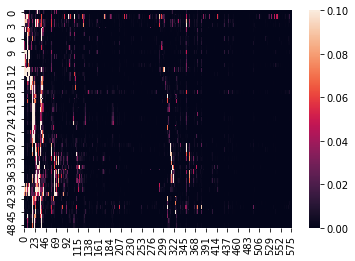

In [495]:
c = 0
cre_str_ind = np.where(~np.isnan(np.sum(connectivity[c], axis = 1) ))[0]
sns.heatmap(connectivity[c,cre_str_ind][:,reorder], vmax = .1)

In [478]:
swoop = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)


In [ ]:
    #def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_vcount_norm_renorm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        
    
    return(output)

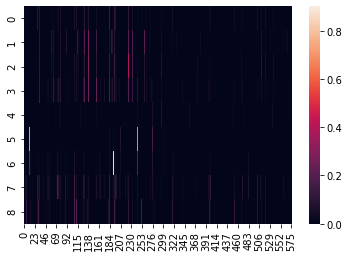

In [485]:
connectivity.shape

(2, 119, 577)

In [486]:
ncre

2

In [487]:
cres

array(['Htr2a-Cre_KM207', 'C57BL/6J'], dtype=object)

In [461]:
np.linalg.norm(connectivity_matrices[c], axis = 1)

array([1.40997001,        nan,        nan,        nan, 0.97127282,
              nan,        nan, 1.22090338, 1.22180346,        nan,
              nan,        nan,        nan, 1.16200374, 1.38631294,
       1.35540619,        nan, 1.41273973, 1.369287  ,        nan,
              nan, 1.36624983,        nan,        nan, 1.41018813,
       1.41056632, 1.41097215,        nan,        nan,        nan,
              nan, 1.06209473,        nan, 1.36709468,        nan,
              nan,        nan,        nan,        nan, 1.39660141,
              nan,        nan,        nan, 1.30360597,        nan,
       1.3492212 ,        nan,        nan,        nan, 1.30502095,
              nan, 1.36331594,        nan, 1.32457583,        nan,
              nan, 1.23729786, 1.31998699,        nan, 1.28161328,
       1.24572427, 1.21408597,        nan,        nan,        nan,
              nan,        nan, 1.37669362,        nan, 1.27996916,
              nan,        nan, 1.21550884, 1.04041334,        

In [458]:
np.sum(connectivity_matrices[c], axis = 1)[1] == 'nan'

False

In [423]:
cres = ['Cux2-IRES-Cre']
structure_dict = leafs
source_ordering = source_ordering_isocortex
target_ordering= target_ordering
structure_major_dictionary = connectivity_data.leaf_major_dictionary

In [424]:
nsource = len(source_ordering)
#n#target = len(target_ordering)
ncre = len(cres)

ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions     

ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    #print(iy)
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)   

reorder = np.concatenate([ipsi_indices, contra_indices])  

ntarget = len(reorder)

connectivity = np.zeros((ncre, nsource, ntarget))
connectivity[:] = np.nan
#structure_major_dictionary = connectivity_data.structure_major_dictionary
for c in range(ncre):
    for i in range(nsource):
        sid = structure_major_dictionary[source_ordering[i]]
        connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)


{667: {'Cux2-IRES-Cre': array([2.64044352e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.77890055e-03, 1.22458566e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.33635801e-03,
       2.25202635e-03, 7.21077775e-04, 1.77752526e-03, 1.34229132e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.72398333e-06,
       1.18653479e-04, 0.00000000e+00, 2.28872053e-01, 0.00000000e+00,
       2.11447470e-02, 0.00000000e+00, 0.00000000e+00, 1.72421943e-02,
       1.35608149e-06, 4.45148834e-05, 9.08923342e-06, 4.64780135e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.56149555e-03, 0.00000000e+00,
       2.44198068e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.44937241e-01, 0.00000000e+00, 1.16837672e-03

KeyError: 'Cux2-IRES-Cre'

In [441]:
reorder.shape

(577,)

In [426]:
structure_data = connectivity_data.structure_datas[sid]
structures = structure_dict[sid]
prediction_region=source_ordering[i]
cre = cres[c]
gamma = gamma
surface = connectivity_data.structure_datas[sid].loss_surface
cre_model = True
#(cache, ,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    

In [429]:
source_ordering[i]

526157192

In [427]:
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_vcount_norm_renorm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

 
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        print(means)
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
      

{526157192: {'C57BL/6J': array([9.61919418e-03, 1.46715776e-05, 0.00000000e+00, 7.29355661e-05,
       3.62598785e-05, 1.17291363e-02, 1.34412171e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.63590851e-03,
       2.91552636e-03, 1.48439125e-03, 1.46348727e-02, 3.13327232e-02,
       9.52880494e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.69800292e-05, 5.21162104e-06, 3.94163241e-06,
       1.11503549e-04, 1.84458663e-04, 1.76949931e-01, 0.00000000e+00,
       6.00544292e-03, 4.75730229e-06, 8.68134266e-06, 1.24344559e-02,
       1.41408723e-02, 1.41992864e-03, 1.07988151e-03, 1.31334899e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.07083890e-04,
       0.00000000e+00, 2.61837598e-03, 3.42608896e-03, 7.21733778e-05,
       5.66877139e-05, 8.20003525e-05, 0.00000000e+00, 3.84356426e-04,
       1.06206892e-05, 0.00000000e+00, 0.00000000e+00, 1.59014671e-03,
       9.01923025e-01, 5.07010863e-04, 3.72650415e-0

KeyError: 'Cux2-IRES-Cre'

In [435]:

    print(2)

In [21]:
    #cre = 'C57BL/6J'
    cre =  'Cux2-IRES-Cre'#'Ntsr1-Cre_GN220'#'Cux2-IRES-Cre'
    #cre = 'Tlx3-Cre_PL56'#'Rbp4-Cre_KL100' #'Cux2-IRES-Cre'
    # def get_connectivity(msvds, cache, ia_map, hyperparameters, source_ordering, target_ordering, leafs, creline,
    #                      experiments_minor_structures, ipsi_key, contra_key, cre_dist, cre = None):
    
    source_exp_countvec, source_exp_countvec_wt = get_countvec(source_ordering, ia_map, creline,
                                                               experiments_minor_structures)

    major_structure_ids = np.asarray(list(msvds.keys()))
    nms = len(major_structure_ids)
    prediction_union_norms = {}
    source_region_save = np.asarray([])

    for m in range(4,5):
        sid = major_structure_ids[m]
        #gamma = 1.#hyperparameters[m]
        minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(ems)))]
        # ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
        prediction_union_norms[m] = {}
        for n in range(len(minor_structures)):
            
            minor_structure_inds = np.where(ems == minor_structures[n])[0]
            print(n, minor_structures[n], len(minor_structure_inds))
            losses = get_crecent_loss(msvds[sid], minor_structure_inds, means_cast, cre,crelines ,minor_structures[n],qqq)
            im = Mask.from_cache(cache,
                structure_ids=[minor_structures[n]],
                hemisphere_id=2)  
            
            weights = np.exp( - losses / gamma)
            weights = weights / weights.sum(axis=0)
            weights[np.where(np.isnan(weights))] = 0.
            predictions = np.dot(weights, msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])

            # average over source region voxels
            union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
            source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
            prediction_union = unionize(predictions.transpose(), union_key)
            prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts, 1)
            source_region_save = np.append(source_region_save, source_regions)


NameError: name 'msvds' is not defined

In [ ]:
    ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
    contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
    target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
    permutation = lambda x: np.argsort(np.argsort(target_order(x)))
    targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                               contra_target_regions[permutation(contra_target_regions)]])
    colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

    # reorder rows and columns
    targ_ords = np.concatenate(
        [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
    row_reorder = np.asarray([])
    source_region_save = np.asarray(source_region_save, dtype=int)
    for i in range(len(source_ordering)):
        inx = np.where(source_region_save == int(source_ordering[i]))[0]
        if len(inx) > 0:
            row_reorder = np.append(row_reorder, inx)
    row_reorder = np.asarray(row_reorder, dtype=int)

    df = pd.DataFrame(cd[row_reorder][:, targ_ords], index=rownames, columns=np.asarray(colnames))